The goal of this Kernel is to attempt to predict the causes of wildfires given data such as location, day of week and so on. I start with some EDA before attempting the machine learning. Often on Kaggle datasets are provided as .csv files, this data file however is an SQLite file and the dates are in Julian date format. So I also show how I dealt with the dates and how I imported the data into pandas.
* Part 1: import libraries and data, convert dates to Gregorian format
* Part 2: EDA
* Part 3: Use machine learning to predict the cause of the fires
* Part 4: Build a system that predicts if the fire was malicious

**Part 1**

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

FPA_FOD_20170508.sqlite



First we need to establish a connection with the database file.

In [2]:
cnx = sqlite3.connect('../input/FPA_FOD_20170508.sqlite')

Then we can create our data frame by running a select query on the DB. I used DB browser for SQLite on my own machine to get some information on the tables and data provided so I know the table I want is called 'Fires'. I don't want or need all the columns so I'll only select those I need:

In [3]:
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", cnx)
print(df.head()) #check the data

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE  
0       0.10  
1       0.25  
2       0.10  
3       0.10  
4       0.10  


The DISCOVERY_DATE field is in Julian Date format. I want to convert this field to Gregorian dates (the date format we use everyday). I can then use the Gregorian date to get some additional data fields - month and day of the week.

In [4]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
print(df.head()) #check the data

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  
0       0.10 2005-02-02  
1       0.25 2004-05-12  
2       0.10 2004-05-31  
3       0.10 2004-06-28  
4       0.10 2004-06-28  


In [5]:
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.weekday_name
df_orig = df.copy() #I will use this copy later
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  MONTH DAY_OF_WEEK  
0       0.10 2005-02-02      2   Wednesday  
1       0.25 2004-05-12      5   Wednesday  
2       0.10 2004-05-31      5      Monday  
3       0.10 2004-06-28      6      Monday  
4       0.10 2004-06-28      6      Monday  


**Part 2**

**Exploratory Data Analysis (EDA):**

The purpose of this kernel is to create some ML that can correctly determine the cause of fire so we can start by looking at the causes of fires in the data:

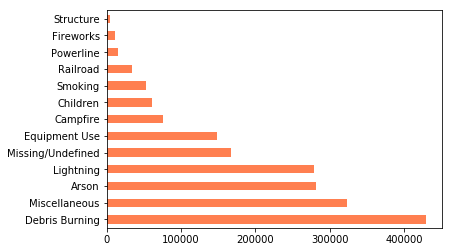

In [6]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.show()

There are 13 causes listed in the dataset. This is quite a lot of classes, one thing I will want to test is: does reducing the number of classes improve the accuracy of the ML and if yes, by how much?

Are fires more likely on certain days of the week?

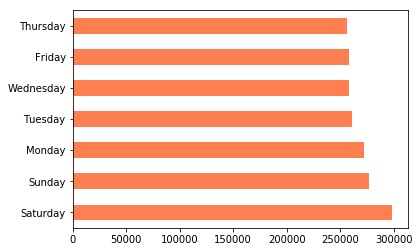

In [7]:
df['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

So fires are slightly more likely to start/be discovered on the weekend. I imagine these fires are due to people being careless with campfires or smoking or possibly malicious fires, I doubt fires due natural causes such as lightning strikes would increase at the weekend. But let's test that:

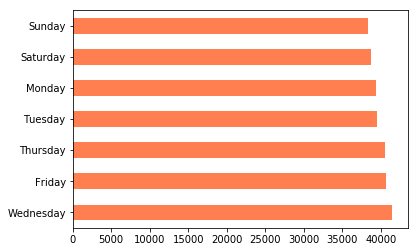

In [8]:
df_lightning = df[df['STAT_CAUSE_DESCR']=='Lightning']
df_lightning['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

There is some small variation but now the weekend is lower. I wonder if the general increase at the weekend is due to malicious fires - Arson:

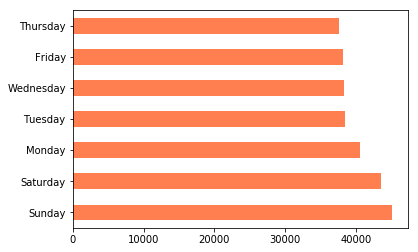

In [9]:
df_arson = df[df['STAT_CAUSE_DESCR']=='Arson']
df_arson['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

I think this shows a more significant trend - Arson is more likely at the weekend than during the week, an increase of around 30% of the average for weekdays. So day of the week may be a useful feature to include in the model.

Which states have the most fires? (to avoid an oversized graphic I'll focus on the top ten)

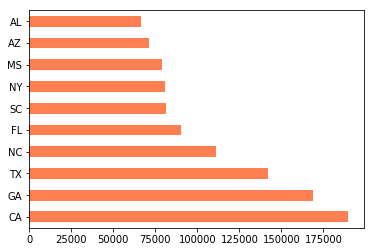

In [10]:
df['STATE'].value_counts().head(n=10).plot(kind='barh',color='coral')
plt.show()

I'm not surprised CA and TX are in the top 3, they are big states with dry climates. I'm surprised to find GA in the top 3, I don't associate GA with wildfires. We can investigate the causes of fires in these 3 states and look for differences. First I need to pull out data for individul states:

In [11]:
df_CA = df[df['STATE']=='CA']
df_GA = df[df['STATE']=='GA']
df_TX = df[df['STATE']=='TX']

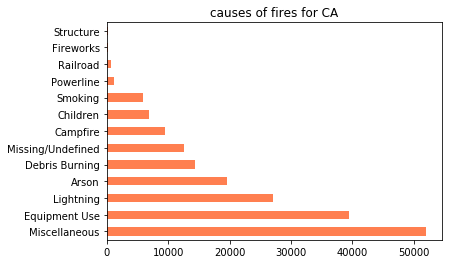

In [12]:
df_CA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral',title='causes of fires for CA')
plt.show()

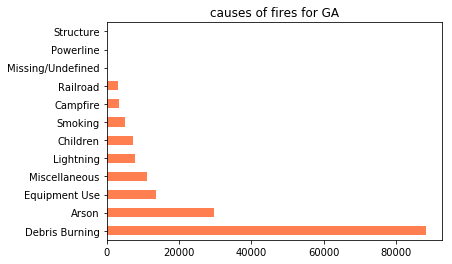

In [13]:
df_GA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral',title='causes of fires for GA')
plt.show()

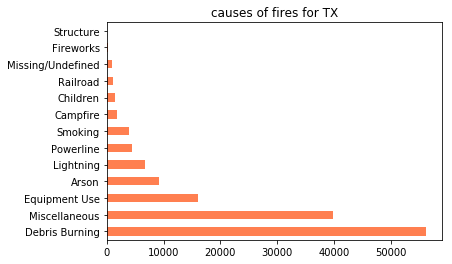

In [14]:
df_TX['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral',title='causes of fires for TX')
plt.show()

There are differences between states so STATE is a useful feature to include in the model. There are two ways of determining fire location in this dataset - STATE or LATITUDE + LONGITUDE

We can get some idea about the geographical coverage of the data by plotting each latitude and longitude pair

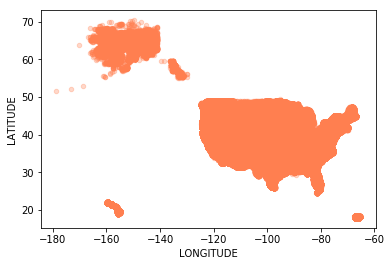

In [15]:
df.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',color='coral',alpha=0.3)
plt.show()

I don't think it is necessary to put this onto an outline map, it is a pretty clear image of the United States. 

To get a better idea of correlation between features we can plot a correlation matrix, first I will convert all features to numeric values, this is necessary for the machine learning stage

In [16]:
le = preprocessing.LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])
df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])
print(df.head())

   FIRE_YEAR  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DATE  \
0       2005                 7  40.036944 -121.005833      4       2453403.5   
1       2004                 6  38.933056 -120.404444      4       2453137.5   
2       2004                 3  38.984167 -120.735556      4       2453156.5   
3       2004                 6  38.559167 -119.913333      4       2453184.5   
4       2004                 6  38.559167 -119.933056      4       2453184.5   

   FIRE_SIZE       DATE  MONTH  DAY_OF_WEEK  
0       0.10 2005-02-02      2            6  
1       0.25 2004-05-12      5            6  
2       0.10 2004-05-31      5            1  
3       0.10 2004-06-28      6            1  
4       0.10 2004-06-28      6            1  


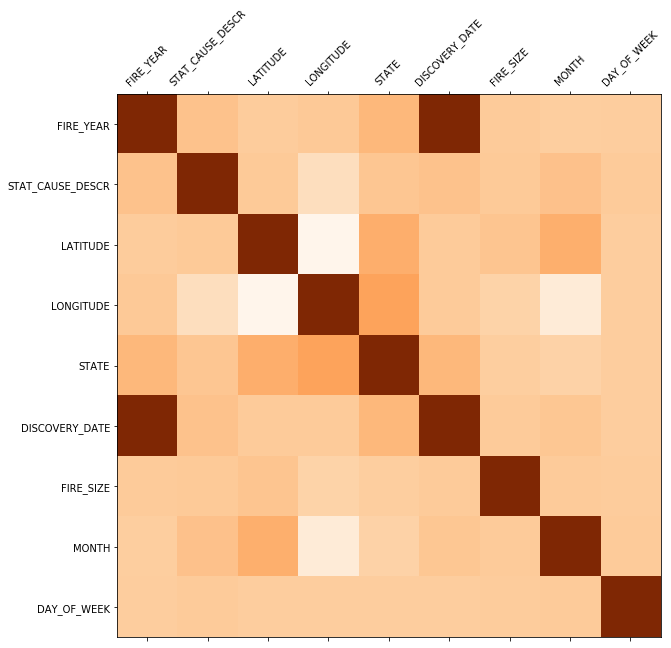

In [17]:
def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    

    
plot_corr(df)

In the above diagram strong correlations are darker, it is supposed to be orange but it looks more like brown to me but anyway darker shades = stronger correlation, white = zero correlation. There is an interesting link between month and latitude, perhaps weather and season related, while there is less correlation between longitude and month. Our target field does not show any particularly strong correlation with any other data feature, perhaps a weak correlation with MONTH, YEAR and DISCOVERY_DATE. 

**Part 3**

**Preparing the data for machine learning**

I have already converted everything to numeric data, but I need to drop the DATE field and drop any NAs

In [18]:
df = df.drop('DATE',axis=1)
df = df.dropna()

The goal is to predict the cause of the fire = STAT_CAUSE_DESCR. Since I'll be using supervised learning I need to create training and test datasets:

In [19]:
X = df.drop(['STAT_CAUSE_DESCR'], axis=1).values
y = df['STAT_CAUSE_DESCR'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0) #30% for testing, 70% for training

On my own machine I tested 3 algorithms: decision tree, random forest and gradient boost. The random forest gave better results than the decision tree (58% compared to 46%). I had to kill the gradient boost, my low spec laptop couldn't cope with this algorithm and the number of rows. I will use random forest here:

In [21]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.580215903854


There are a lot of different classes, I want to put some of these together and have just 4 classes for the cause of fires. Then test again to see if the score improves. The 4 classes are: natural, accidental, malicious and other where natural = ['Lightning'] accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning'] malicious = ['Arson'] other = ['Missing/Undefined','Miscellaneous']

In [22]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
     

df['LABEL'] = df_orig['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) # I created a copy of the original df earlier in the kernel
df = df.drop('STAT_CAUSE_DESCR',axis=1)
print(df.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DATE  FIRE_SIZE  MONTH  \
0       2005  40.036944 -121.005833      4       2453403.5       0.10      2   
1       2004  38.933056 -120.404444      4       2453137.5       0.25      5   
2       2004  38.984167 -120.735556      4       2453156.5       0.10      5   
3       2004  38.559167 -119.913333      4       2453184.5       0.10      6   
4       2004  38.559167 -119.933056      4       2453184.5       0.10      6   

   DAY_OF_WEEK  LABEL  
0            6      4  
1            6      1  
2            1      2  
3            1      1  
4            1      1  


I've now replaced STAT_CAUSE_DESCR with LABEL. So now I will now try to predict LABEL

In [23]:
X = df.drop(['LABEL'], axis=1).values
y = df['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.701738930053


Reducing the number of catagories improved the prediction score significantly (from around 58% to 70%)
Prediction score is a good metric to measure success but we can look at other metrics:

In [24]:
from sklearn.metrics import confusion_matrix
y_pred = clf_rf.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
print(cm)

[[ 67924  10294    841   4257]
 [ 10259 200261  16969  21839]
 [  1478  36283  38718   7691]
 [  6699  46392   5285  88950]]


We can normalize this and visualize the result:

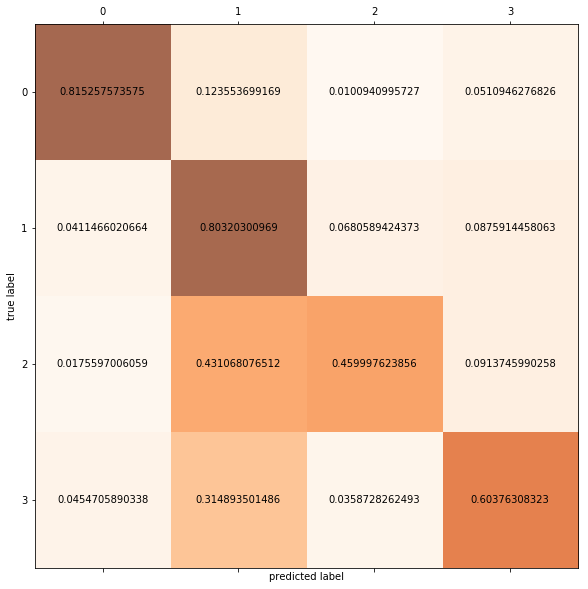

In [25]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(10,10))
ax.matshow(cmn,cmap=plt.cm.Oranges,alpha=0.7)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j,y=i,s=cmn[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

The random forest algorithm did well with the first two labels: natural and accidental (80% +) but did not do as well with the 'other' label and did quite badly with the 'malicious' label, it mistakingly labelled many of these as accidental

**Summary**: 
The original question was: Can we predict the cause of these wildfires using the data provided? The answer is yes, at least to an accuracy of 58% or better. Reducing the number of labels significantly improves the prediction score to 70% for the random forest algorithm. The algorithm did not perform well when trying to distingusih 'accidental' and 'malicious' causes. But with further tuning or a different algorithm it may be possible to fix this.


**Part 4**

Given that it is easier to make accurate predictions if the number of classes is reduced,I wanted to look at just one state (CA) and build a system that can predict if a fire was started maliciously given just some easy to obtain data: year, month, day of week, latitude and longitude of fire. I will drop the FIRE_SIZE field because I want a system that could be used in the early stages of a fire to predict if the fire is the result of Arson. My goal is to use this data to get at least 90% accuracy

In [26]:
print(df_CA.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  MONTH DAY_OF_WEEK  
0       0.10 2005-02-02      2   Wednesday  
1       0.25 2004-05-12      5   Wednesday  
2       0.10 2004-05-31      5      Monday  
3       0.10 2004-06-28      6      Monday  
4       0.10 2004-06-28      6      Monday  


Create a new field: ARSON

In [27]:
def set_arson_label(cause):
    arson = 0
    if cause == 'Arson':
        arson = 1
    return arson
     

df_CA['ARSON'] = df_CA['STAT_CAUSE_DESCR'].apply(lambda x: set_arson_label(x)) 
print(df_CA.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  MONTH DAY_OF_WEEK  ARSON  
0       0.10 2005-02-02      2   Wednesday      0  
1       0.25 2004-05-12      5   Wednesday      0  
2       0.10 2004-05-31      5      Monday      0  
3       0.10 2004-06-28      6      Monday      0  
4       0.10 2004-06-28      6      Monday      0  


We can drop the DATE, STATE, FIRE_SIZE and STAT_CAUSE_DESCR fields and convert the DAY_OF_WEEK to numerical values.

In [28]:
df_CA = df_CA.drop('DATE',axis=1)
df_CA = df_CA.drop('STATE',axis=1)
df_CA = df_CA.drop('STAT_CAUSE_DESCR',axis=1)
df_CA = df_CA.drop('FIRE_SIZE',axis=1)
df_CA = df_CA.dropna()

le = preprocessing.LabelEncoder()
df_CA['DAY_OF_WEEK'] = le.fit_transform(df_CA['DAY_OF_WEEK'])

print(df_CA.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  DISCOVERY_DATE  MONTH  DAY_OF_WEEK  ARSON
0       2005  40.036944 -121.005833       2453403.5      2            6      0
1       2004  38.933056 -120.404444       2453137.5      5            6      0
2       2004  38.984167 -120.735556       2453156.5      5            1      0
3       2004  38.559167 -119.913333       2453184.5      6            1      0
4       2004  38.559167 -119.933056       2453184.5      6            1      0


We can now test the ML:

In [29]:
X = df_CA.drop(['ARSON'], axis=1).values
y = df_CA['ARSON'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0) #30% for testing, 70% for training
clf_rf = ske.RandomForestClassifier(n_estimators=200)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.921146575222


So this meets the goal of 90% or better. 

Summary:
Given some basic data, the kind of data available when a fire is first discovered, it is possible to predict with some accuracy if the firs wa the result of arson.